In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

# look at all dsets

In [128]:
ddir = 'iaip_data/Datasets'
fnames = sorted([fname for fname in os.listdir(ddir) 
                 if 'csv' in fname
                 and not 'formats' in fname])
feature_names = [fname[:-4].replace('form', '').replace('-', '_') for fname in fnames]
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv')
# print(fnames)

In [129]:
r = {}
for fname in tqdm(fnames):
    df = pd.read_csv(oj(ddir, fname), engine='python')
    df.rename(columns={'SubjectID': 'id'}, inplace=True)
    df.rename(columns={'subjectid': 'id'}, inplace=True)
    assert('id' in df.keys())
    r[fname] = df


100%|██████████| 68/68 [00:01<00:00, 40.93it/s]

In [80]:
num_patients = np.unique(r[fnames[0]]['id'].values).size
missing_arr = np.zeros((len(fnames), num_patients + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
    df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

In [ ]:
plt.figure(figsize=(5, 10))
sns.barplot(x=missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients')
plt.savefig('num_patients.png')
plt.show()

<Figure size 3600x6000 with 0 Axes>

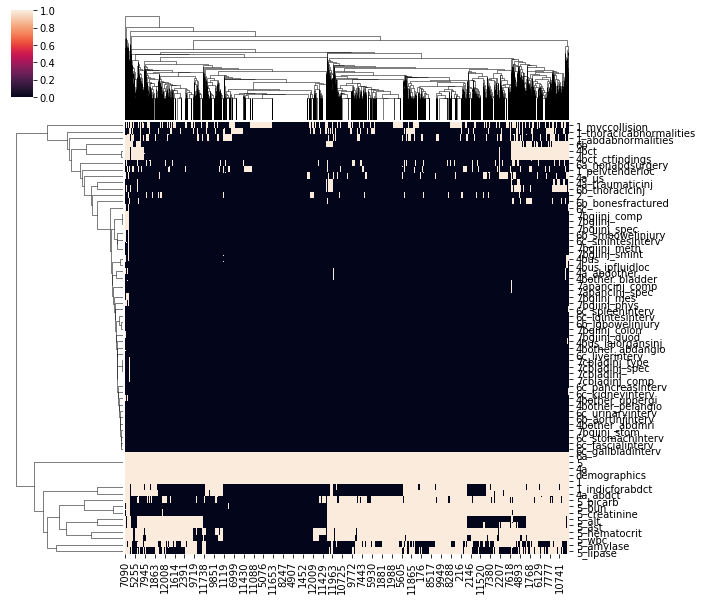

In [107]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=feature_names)
# plt.tight_layout()
plt.savefig('missing.png')
plt.show()

# make features 

**merge everything**

In [150]:
df = r[fnames[0]]
how = 'outer'
for i, fname in tqdm(enumerate(fnames[1:8])):
    df2 = r[fname].copy()
    rename_dict = {
        key: key + '_' + feature_names[i + 1][:8] 
        for key in df2.keys()
        if not key == 'id'
    }
    df2.rename(columns=rename_dict, inplace=True)
    df = pd.merge(df, df2, on='id', how=how)


0it [00:00, ?it/s]
5it [00:00, 48.39it/s]
7it [00:00, 43.46it/s]

**code features**

In [161]:
# for k in ['RACE', 'SEX']:
#     df[k] = df[k].astype(str)
for k in ['ageinyrs']:
    df[k] = df[k].astype(float)

In [ ]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

In [163]:
df.keys()

Index(['id', 'SEX', 'RACE', 'OTHER_RACE', 'HISPANIC_ETHNICITY', 'ageinyrs',
       'EDTriageDay_1', 'EDTriageTime_1', 'InjuryDay_1', 'InjuryTime_1',
       ...
       'AbdCTScan_2', 'KnowAbCTRes_2', 'AbdTrauma_2', 'SeatBeltSign_2',
       'AbdDistention_2', 'BowelSounds_2', 'AbdomenTender_2',
       'AbdTenderDegree_2', 'AbdTenderLoc_2', 'PeritonIrrit_2'],
      dtype='object', length=137)

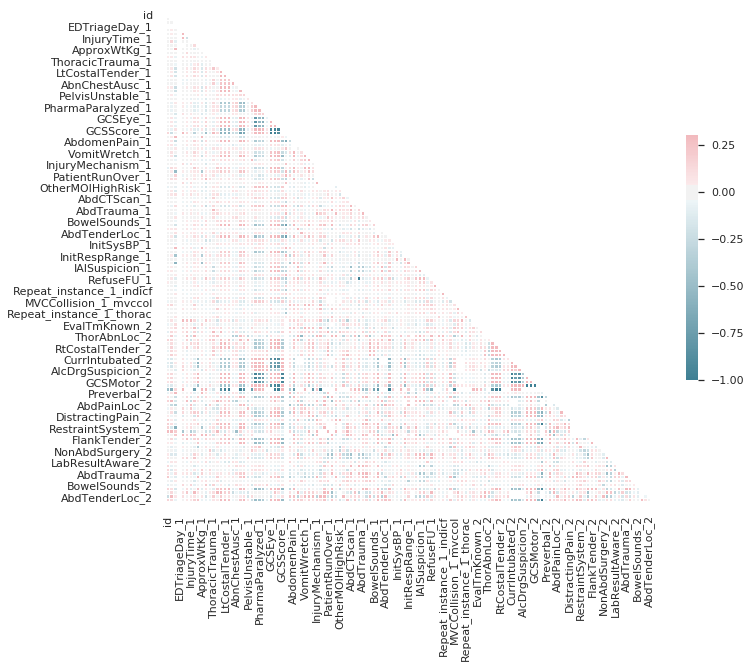

In [168]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

***outcome***

In [2]:
outcomes_full_surg = pd.read_csv('iaip_data/Datasets/form6c.csv')
outcome_serious = pd.DataFrame({
    'id': outcomes_full_surg.subjectid,
    'outcome_surge': np.ones(outcomes_full_surg.subjectid.size)
})

# Intra-abdominal injury diagnosed in the ED/during hospitalization by any diagnostic method
# 1 is yes
# 2 is no -> remap to 0
outcomes_full_pi = pd.read_csv('iaip_data/Datasets/form6b.csv')
outcomes_full_pi.keys()
outcomes_full_pi['id'] = outcomes_full_pi['SubjectID'] 
idxs = outcomes_full_pi['IAIinED1'] == 2
outcomes_full_pi.loc[idxs, 'IAIinED1'] = 0
outcomes = outcomes_full_pi[['id', 'IAIinED1']]